## SiameseNet模型搭建

In [1]:
from data_load import load_char_data, get_embed
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset
import numpy as np

将'我爱学习'文本转化为id序列579 545 35 799 
id_list转化为嵌入向量为
[ 1.79629400e+00  2.51598120e+00  1.82228640e+00 -3.53821160e+00
  1.99003430e+00 -2.30876790e-01  1.03420600e+00 -1.01830220e+00
 -3.21812240e-01 -1.52446540e+00 -9.26450250e-01  4.37394680e-01
  1.91165830e-01  2.55095330e-01 -2.22546630e+00  7.01172100e-01
  3.40463230e+00  2.32615610e+00 -1.45944270e+00 -2.23996950e+00
  3.06487830e-02  1.17222360e+00 -4.57386060e+00  1.06058770e-01
 -1.43589580e+00 -1.63493960e+00 -3.04952030e-01  1.70673070e-01
 -2.68366960e+00 -2.61135980e+00  2.69963200e+00  2.73121140e+00
 -1.21422040e+00  1.75877790e+00  1.26100090e+00 -4.85585100e-01
  9.02912200e-01 -7.35035240e-01 -1.96040900e-01 -2.51912360e+00
 -2.91899230e-01 -4.74387600e-01 -3.05935550e+00  4.04685400e+00
  3.44127630e+00  1.25115690e+00 -1.58445160e+00 -2.80243870e+00
 -2.95927670e-01 -9.60050900e-01  5.19874040e-01 -3.38323000e+00
 -5.32603450e+00 -2.45540450e+00 -4.37591500e+00  3.62992440e-01
 -2.19670990e+00 -4.98429000e-02  3.195730

## 参数设置

In [2]:
CHAR_SIZE=20029
embedding_size=300
lstm_hidden_size=64
linear_hidden_size=128
m=0.3

EPOCH=5
BATCH_SIZE=100
LR=0.001

vocab_file='./data/token_vec_300.bin'
embed,char2idx, idx2char = get_embed(vocab_file)

In [3]:
class SiameseNet(nn.Module):
    def __init__(self):
        super(SiameseNet, self).__init__()
        self.embedding=nn.Embedding(CHAR_SIZE, embedding_size)
        self.embedding.weight.data.copy_(torch.from_numpy(embed))
        self.bi_lstm=nn.LSTM(embedding_size, lstm_hidden_size, num_layers=2, dropout=0.2,
                            batch_first=True, bidirectional=True)
        self.dense=nn.Linear(linear_hidden_size, linear_hidden_size)
        self.dropout=nn.Dropout(p=0.4)
        
    def forward(self, a, b):
        embed_a = self.embedding(a)
        embed_b = self.embedding(b)
        
        lstm_a, (h_a, c_a) = self.bi_lstm(embed_a)
        lstm_b, (h_b, c_b) = self.bi_lstm(embed_b)
        
        avg_a = torch.mean(lstm_a, dim=1)
        avg_b = torch.mean(lstm_b, dim=1)
        
        out_a = torch.tanh(self.dense(avg_a))
        out_a = self.dropout(out_a)
        out_b = torch.tanh(self.dense(avg_b))
        out_b = self.dropout(out_b)
        
        cosine=torch.cosine_similarity(out_a, out_b, dim=1, eps=1e-8)
        return cosine

### 需定义自己的数据集，模板格式如下

In [4]:
class LcqmcDataset(Dataset):
    def __init__(self, filepath, vocab_file):
        self.path = filepath
        self.a_index, self.b_index, self.label = load_char_data(filepath, vocab_file)
        
    def __len__(self):
        return len(self.a_index)
    
    def __getitem__(self, idx):
        return self.a_index[idx], self.b_index[idx], self.label[idx]

In [5]:
train_path = './data/lcqmc_train.tsv'
train_data = LcqmcDataset(train_path, vocab_file)
train_data[10]

(array([  89,   47,  133,  673,    2,   12,  992, 1205, 1542,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0]),
 array([2665,   47,  133,   12,  992, 1205,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0]),
 0)

In [6]:
class ContrastiveLoss(nn.Module):
    def __init__(self):
        super(ContrastiveLoss, self).__init__()
        
    def forward(self, Ew, y):
        l_1 = 0.25*(1.0-Ew)*(1.0-Ew)
        l_0 = torch.where(Ew<m*torch.ones_like(Ew), torch.full_like(Ew, 0), Ew)*torch.where(Ew<m*torch.ones_like(Ew),torch.full_like(Ew,0),Ew)
        
        # 1.0为了保证pytorch可对其进行梯度后向传播
        loss = y*l_1+(1-y)*l_0
        return loss.sum()

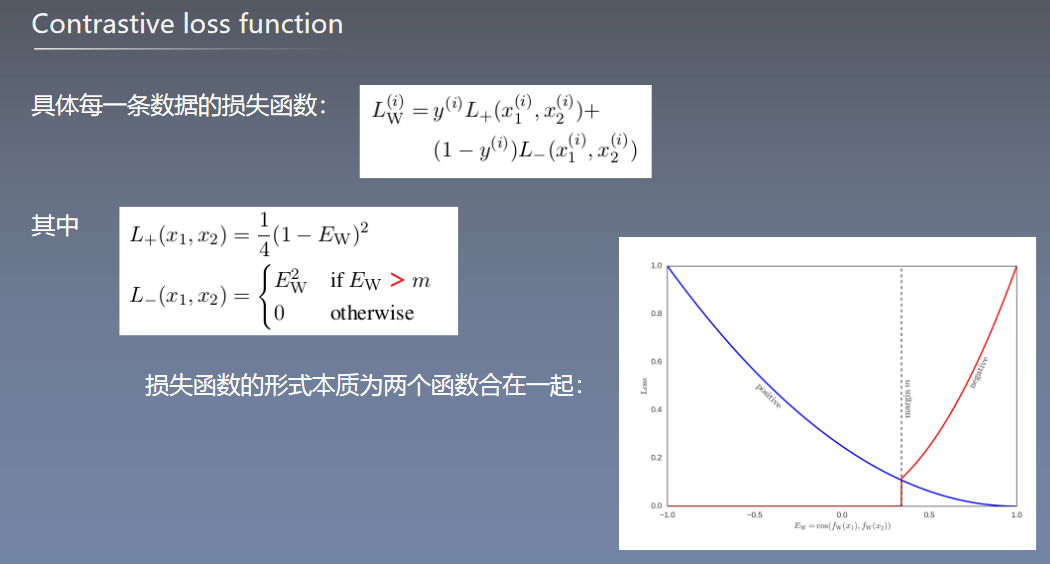

In [7]:
train_path='./data/lcqmc_train.tsv'
test_path='./data/lcqmc_test.tsv'

train_data=LcqmcDataset(train_path, vocab_file)
test_data=LcqmcDataset(test_path, vocab_file)
train_loader=DataLoader(dataset=train_data,batch_size=BATCH_SIZE,shuffle=True)
test_loader=DataLoader(dataset=test_data,batch_size=BATCH_SIZE,shuffle=True)

#2、有gpu用gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device=torch.device('cpu')
net=SiameseNet().to(device)

#3、定义优化方式和损失函数
optimizer=torch.optim.Adam(net.parameters(),lr=LR)
loss_func=ContrastiveLoss()

In [8]:
for epoch in range(EPOCH):
    for step, (text_a, text_b, label) in enumerate(train_loader):
        a=text_a.to(device).long()
        b=text_b.to(device).long()
        l=torch.LongTensor(label).float().to(device)
        
        cosine=net(a, b)
        
        loss=loss_func(cosine, l)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if step % 200 == 0:
            total = 0
            correct = 0
            for (test_a, test_b, l) in test_loader:
                tst_a = test_a.to(device).long()
                tst_b = test_b.to(device).long()
                tst_l = l.to(device).long()
                cosine = net(tst_a, tst_b)
                out=torch.Tensor(np.array([1 if cos > m else 0 for cos in cosine])).long()
           #     print(out)
                if out.size()==tst_l.size():
                    total+=tst_l.size(0)
                    correct+=(out==tst_l.cpu()).sum().item()
            print('[Epoch ~ Step]:',epoch+1,'~',step+1,'训练loss:',loss.item())
            print('[Epoch]:',epoch+1,'测试集准确率: ',(correct*1.0/total))

[Epoch ~ Step]: 1 ~ 1 训练loss: 16.87604331970215
[Epoch]: 1 测试集准确率:  0.50024
[Epoch ~ Step]: 1 ~ 201 训练loss: 7.637860298156738
[Epoch]: 1 测试集准确率:  0.618
[Epoch ~ Step]: 1 ~ 401 训练loss: 8.726348876953125
[Epoch]: 1 测试集准确率:  0.62632
[Epoch ~ Step]: 1 ~ 601 训练loss: 7.296784400939941
[Epoch]: 1 测试集准确率:  0.63928
[Epoch ~ Step]: 1 ~ 801 训练loss: 9.365312576293945
[Epoch]: 1 测试集准确率:  0.64272
[Epoch ~ Step]: 1 ~ 1001 训练loss: 7.410923004150391
[Epoch]: 1 测试集准确率:  0.63904
[Epoch ~ Step]: 1 ~ 1201 训练loss: 6.8828864097595215
[Epoch]: 1 测试集准确率:  0.65304
[Epoch ~ Step]: 1 ~ 1401 训练loss: 7.610716819763184
[Epoch]: 1 测试集准确率:  0.65536
[Epoch ~ Step]: 1 ~ 1601 训练loss: 7.020771026611328
[Epoch]: 1 测试集准确率:  0.6564
[Epoch ~ Step]: 1 ~ 1801 训练loss: 8.06717586517334
[Epoch]: 1 测试集准确率:  0.6628
[Epoch ~ Step]: 1 ~ 2001 训练loss: 7.905709266662598
[Epoch]: 1 测试集准确率:  0.66192
[Epoch ~ Step]: 1 ~ 2201 训练loss: 8.181428909301758
[Epoch]: 1 测试集准确率:  0.66824
[Epoch ~ Step]: 2 ~ 1 训练loss: 6.633835792541504
[Epoch]: 2 测试集准

KeyboardInterrupt: 